### Import packages

In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sb
import scipy.stats as stats
import scipy
import ast
import warnings
import pylab
import matplotlib.pyplot as plt
import math
import pingouin as pg

warnings.filterwarnings('ignore')

### Load & Organize Data

In [2]:
path = 'behavioral_data/MRI_Behavioral_Data/'

Make a list of dataframes for all the runs we use in the MRI analysis

In [3]:
# first, read in the runs and run files we need to ignore

exclude_file    = [ x for x in os.listdir('.') if 'exclude' in x   ]
disregard_files = [ x for x in os.listdir('.') if 'disregard' in x ]
disregard_dfs   = [ pd.read_csv(x).T for x in disregard_files ]

### First, data to exclude

In [4]:
pd.read_csv(exclude_file[0])

,Unnamed: 0,run,count,subject
0,1,2.0,8,behavioral_data/MRI_Behavioral_Data/subject_21
1,2,3.0,15,behavioral_data/MRI_Behavioral_Data/subject_21
2,3,4.0,11,behavioral_data/MRI_Behavioral_Data/subject_21


^^ We will exclude runs 2, 3, and 4 from subject 21

We also exclude subject_17

### Then, log files to ignore

In [5]:
disregard_subs = pd.concat(disregard_dfs)[0].unique()
disregard_subs

array(['subject', 'subject_12', 'subject_4', 'subject_20'], dtype=object)

In [6]:
disregard_logs = pd.concat(disregard_dfs)[1].unique()
disregard_logs

array(['file',
       'behavioral_data/MRI_Behavioral_Data/subject_12/subject_12_run_1_2023-09-01_14h48.28.289.log',
       'behavioral_data/MRI_Behavioral_Data/subject_4/subject_4c_run_1_2023-08-24_13h14.00.218.log',
       'behavioral_data/MRI_Behavioral_Data/subject_20/subjec_20b_run_1_2023-11-02_17h48.21.836.log'],
      dtype=object)

In [7]:
disregard_csvs = [ x[:-4]+'.csv' for x in disregard_logs ]
disregard_csvs

['.csv',
 'behavioral_data/MRI_Behavioral_Data/subject_12/subject_12_run_1_2023-09-01_14h48.28.289.csv',
 'behavioral_data/MRI_Behavioral_Data/subject_4/subject_4c_run_1_2023-08-24_13h14.00.218.csv',
 'behavioral_data/MRI_Behavioral_Data/subject_20/subjec_20b_run_1_2023-11-02_17h48.21.836.csv']

In [8]:
extra_runs = ['behavioral_data/subject_1/sub_1_run_1_2023-08-18_12h17.09.696.csv',
              'behavioral_data/subject_12/subject_12_run_1_2023-09-01_15h08.30.551.csv'
             ]

### Create function to add response type 

In [9]:
def add_type(data):
    # Organize scores
    data['response_type'] = np.nan
    data['response_value'] = np.nan

    # Handle cases with two responses
    if data.loc[data['key_resp_9.keys'].str.contains(',', na=False), 'key_resp_9.keys'].shape[0] > 0:
        data.loc[data['key_resp_9.keys'].str.contains(',', na=False), 'key_resp_9.keys'] = data['key_resp_9.keys'].str.split(',').str[0]

    # Assign response_value based on 'key_resp_9.keys'
    data['response_value'] = data['key_resp_9.keys'].str[2]

    # Set response_type based on conditions
    data.loc[(data['response_value'] == '1') & (data['type'].str.contains('veridical', na=False)), 'response_type'] = 'Hit'
    data.loc[(data['response_value'] == '1') & (data['type'].str.contains('scrambled', na=False)), 'response_type'] = 'False Alarm'
    data.loc[(data['response_value'] == '2') & (data['type'].str.contains('veridical', na=False)), 'response_type'] = 'Miss'
    data.loc[(data['response_value'] == '2') & (data['type'].str.contains('scrambled', na=False)), 'response_type'] = 'Correct Reject'

    # Handle unanswered responses
    data['unanswered'] = data['key_resp_9.keys'].isna() | data['key_resp_9.keys'].str.contains('None', na=False)
    
    return data

In [10]:
# Initialize the list of dataframes
data_dfs = []

# Define your path
base_path = 'behavioral_data/MRI_Behavioral_Data/'

# Iterate over each subject in the behavioral_data directory
for sub in os.listdir(base_path):
    # Check if the folder is a subject and not the excluded subject
    if sub != 'subject_17' and sub.startswith('subject_'):
        # Full path to the subject's directory
        sub_dir = os.path.join(base_path, sub)
        
        # List all csv files in the current subject's directory
        csvs = [
            os.path.join(sub_dir, x) for x in os.listdir(sub_dir)
            if x.endswith('.csv')
            and os.path.join(sub_dir, x) not in disregard_csvs
            and os.path.join(sub_dir, x) not in extra_runs
        ]
        
        # Read them as dataframes and add to data_dfs
        for csv_file in csvs:
            try:
                df = pd.read_csv(csv_file)
                df = add_type(df)  
                data_dfs.append(df)
            except Exception as e:
                print(f"Error reading {csv_file}: {e}")

In [11]:
# Combine all dataframes into one dataframe
new_data = pd.concat(data_dfs, ignore_index=True)

# Correct participant labels
new_data.loc[new_data['participant'] == 'subject_16c3', 'participant'] = 'subject_16c'

# Exclude runs 2, 3, 4 for subject_21 and remove any rows where run is NaN
new_data = new_data[~((new_data['participant'] == 'subject_21') & (new_data['run'].isin([2, 3, 4])))]
new_data = new_data[~new_data['run'].isna()]

unique_participants = new_data[~new_data['participant'].isna()]['participant'].unique()
print(f"Number of unique participants: {len(unique_participants)}")

Number of unique participants: 22


In [12]:
# Initialize 'Video Type' and related columns if they don't already exist
if 'Video Type' not in new_data.columns:
    new_data['Video Type'] = np.nan
if 'Participant Judgement' not in new_data.columns:
    new_data['Participant Judgement'] = np.nan
if 'Judged Correctly' not in new_data.columns:
    new_data['Judged Correctly'] = np.nan

# Populate 'Video Type'
new_data.loc[new_data['response_type'].isin(['Hit', 'Miss']), 'Video Type'] = 'Real Attention'
new_data.loc[new_data['response_type'].isin(['False Alarm', 'Correct Reject']), 'Video Type'] = 'Fake Attention'

# Populate 'Participant Judgement' and 'Judged Correctly'
new_data.loc[new_data['response_type'].isin(['Hit', 'False Alarm']), 'Participant Judgement'] = 'Judged Real'
new_data.loc[new_data['response_type'].isin(['Miss', 'Correct Reject']), 'Participant Judgement'] = 'Judged Fake'
new_data.loc[new_data['response_type'].isin(['Hit', 'Correct Reject']), 'Judged Correctly'] = 'Correct'
new_data.loc[new_data['response_type'].isin(['Miss', 'False Alarm']), 'Judged Correctly'] = 'Wrong'

# Check the output after setting the columns
print(new_data[['participant', 'run', 'response_type', 'Video Type', 'Participant Judgement', 'Judged Correctly']].head(10))

   participant  run   response_type      Video Type Participant Judgement  \
1   subject_4c  2.0     False Alarm  Fake Attention           Judged Real   
2   subject_4c  2.0             Hit  Real Attention           Judged Real   
3   subject_4c  2.0     False Alarm  Fake Attention           Judged Real   
4   subject_4c  2.0             Hit  Real Attention           Judged Real   
5   subject_4c  2.0  Correct Reject  Fake Attention           Judged Fake   
6   subject_4c  2.0             Hit  Real Attention           Judged Real   
7   subject_4c  2.0             Hit  Real Attention           Judged Real   
8   subject_4c  2.0  Correct Reject  Fake Attention           Judged Fake   
9   subject_4c  2.0             NaN             NaN                   NaN   
10  subject_4c  2.0            Miss  Real Attention           Judged Fake   

   Judged Correctly  
1             Wrong  
2           Correct  
3             Wrong  
4           Correct  
5           Correct  
6           Correct 

In [13]:
new_data.to_csv("behavioral_data.csv", index=False)

In [14]:
new_data.shape[0]

2620

In [15]:
1 - (new_data[new_data['response_type'].isna()].shape[0] / new_data[~new_data['response_type'].isna()].shape[0])


0.9741581832419733

### Plot the results

In [32]:
def add_dprime(data):
    '''
    adds dprime column to dataframe with dprime values for each subject
    '''
    
    # make new d-prime column in the data
    data['dprime'] = np.nan
    
    # for each subject in the df:
    for p in data['participant'].unique():
    
        # get the number of trials they responded to
        responses = new_data[~(new_data['response_type'].isna()) & (new_data['participant']==p)].shape[0]
        
        # get number of hits, misses, false alarms, correct rejections
        hit  = new_data[(new_data['response_type']=='Hit') & (new_data['participant']==p)].shape[0]
        miss = new_data[(new_data['response_type']=='Miss') & (new_data['participant']==p)].shape[0]
        fa   = new_data[(new_data['response_type']=='False Alarm') & (new_data['participant']==p)].shape[0]
        cr   = new_data[(new_data['response_type']=='Correct Reject') & (new_data['participant']==p)].shape[0]
        
        # calculate hit rate
        hit_rate = hit / new_data[(new_data['participant']==p)
                                  & (new_data['Video Type']=='Real Attention')
                                  & ~(new_data['response_type'].isna())
                                 ].shape[0]
        
        # calculate false alarm rate
        fa_rate = fa / new_data[(new_data['participant']==p) 
                                & (new_data['Video Type']=='Fake Attention')
                                & ~(new_data['response_type'].isna())
                               ].shape[0]
        
        # calculate d-prime
        d_prime = scipy.stats.norm.ppf(hit_rate) - scipy.stats.norm.ppf(fa_rate)
        
        # add d-prime value to d-prime column for all rows for that participant
        data.loc[data['participant']==p,'dprime'] = d_prime
        
    return(data)

In [33]:
d_prime_data = add_dprime(new_data)

In [34]:
plot_prime = d_prime_data.groupby(['participant'],as_index=False)['dprime'].mean()

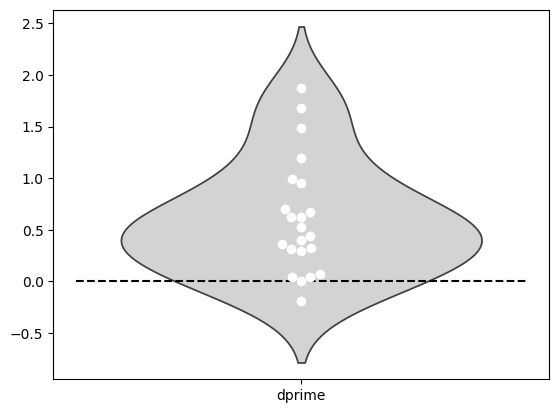

In [35]:
sb.violinplot(plot_prime, inner=None, color='lightgray')
sb.swarmplot(plot_prime, color='white', size=7)
plt.hlines(y=0, xmin=-.5,xmax=.5, color='k', linestyle='--')
plt.savefig('dprime_light.pdf')

In [36]:
scipy.stats.ttest_1samp(plot_prime['dprime'],0)

TtestResult(statistic=5.162937906370936, pvalue=4.083541073224179e-05, df=21)